
# Derivative of scaled function 

Assume that we have access
$$
x \mapsto f^{\prime}(x).
$$
for some special structured function $f$. This computation needs calling $x \mapsto f(x).$

Now, we consider the scaled function of $f$: for some $k \in \mathbb{R}$,
$$
g(x) := f(kx).
$$
We want to compute 
$$
x \mapsto g^{\prime}(x).
$$
The derivative of $g(x)$ is
$$
    g^{\prime}(x)=k \cdot f^{\prime}(k x).
$$
Thus, we can compute $x \mapsto g^{\prime}(x)$ by three steps:
\begin{enumerate}
    \item Define $u = kx$. Then, calling function $f$ is equivalent to calling
$$
u \mapsto f(u) = g (\frac{1}{k}u).
$$
\item Use $u \mapsto f(u) $ to compute $f^{\prime}(u)$ at $u=kx$.
\item Compute $g^{\prime}(x)=k \cdot f^{\prime}(u).$
\end{enumerate}


## GENERAL TEST

In [3]:
import numpy as np

# 定义函数 f(x) = sin(x)
def f(x):
    return np.sin(x)+np.cos(x)+np.sin(2*x)+np.cos(2*x)

# 定义数值微分方法
def central_difference(f, x, h):
    return (f(x + h) - f(x - h)) / (2 * h)

# 选择点 x 和步长 h
x = np.random.rand() * 10  # 在 [0, 10) 内随机选择一个点
h = 1e-5 

K = 2
def g(x):
    return f(K*x)

def g_prime_theoretical(x):
    scaled_g = lambda x: g(x/K)
    return K * central_difference(scaled_g, K *x, h)

theoretical = g_prime_theoretical(x)
central = central_difference(g, x, h)
print(f"Central difference estimate: {central}")
print(f"Difference between theoretical and central difference: {np.abs(theoretical - central):.2e}")


Central difference estimate: 1.6900609487113802
Difference between theoretical and central difference: 7.33e-10


## VQA TEST

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh

import os
import pickle

from qiskit import transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit

from algo.utils import find_pauli_indices
from algo.utils import hamiltonian_to_matrix
from algo.utils import process_hamiltonian_Zs
from algo.utils import optimal_interp_points
from algo.utils import interp_matrix

In [5]:
num_q = 8 # N # IMPORTANT

# Generate a random complex matrix
A = np.random.rand(2**num_q, 2**num_q) + 1j * np.random.rand(2**num_q, 2**num_q)
# Make it Hermitian
Hmat = (A + A.conj().T) / 2

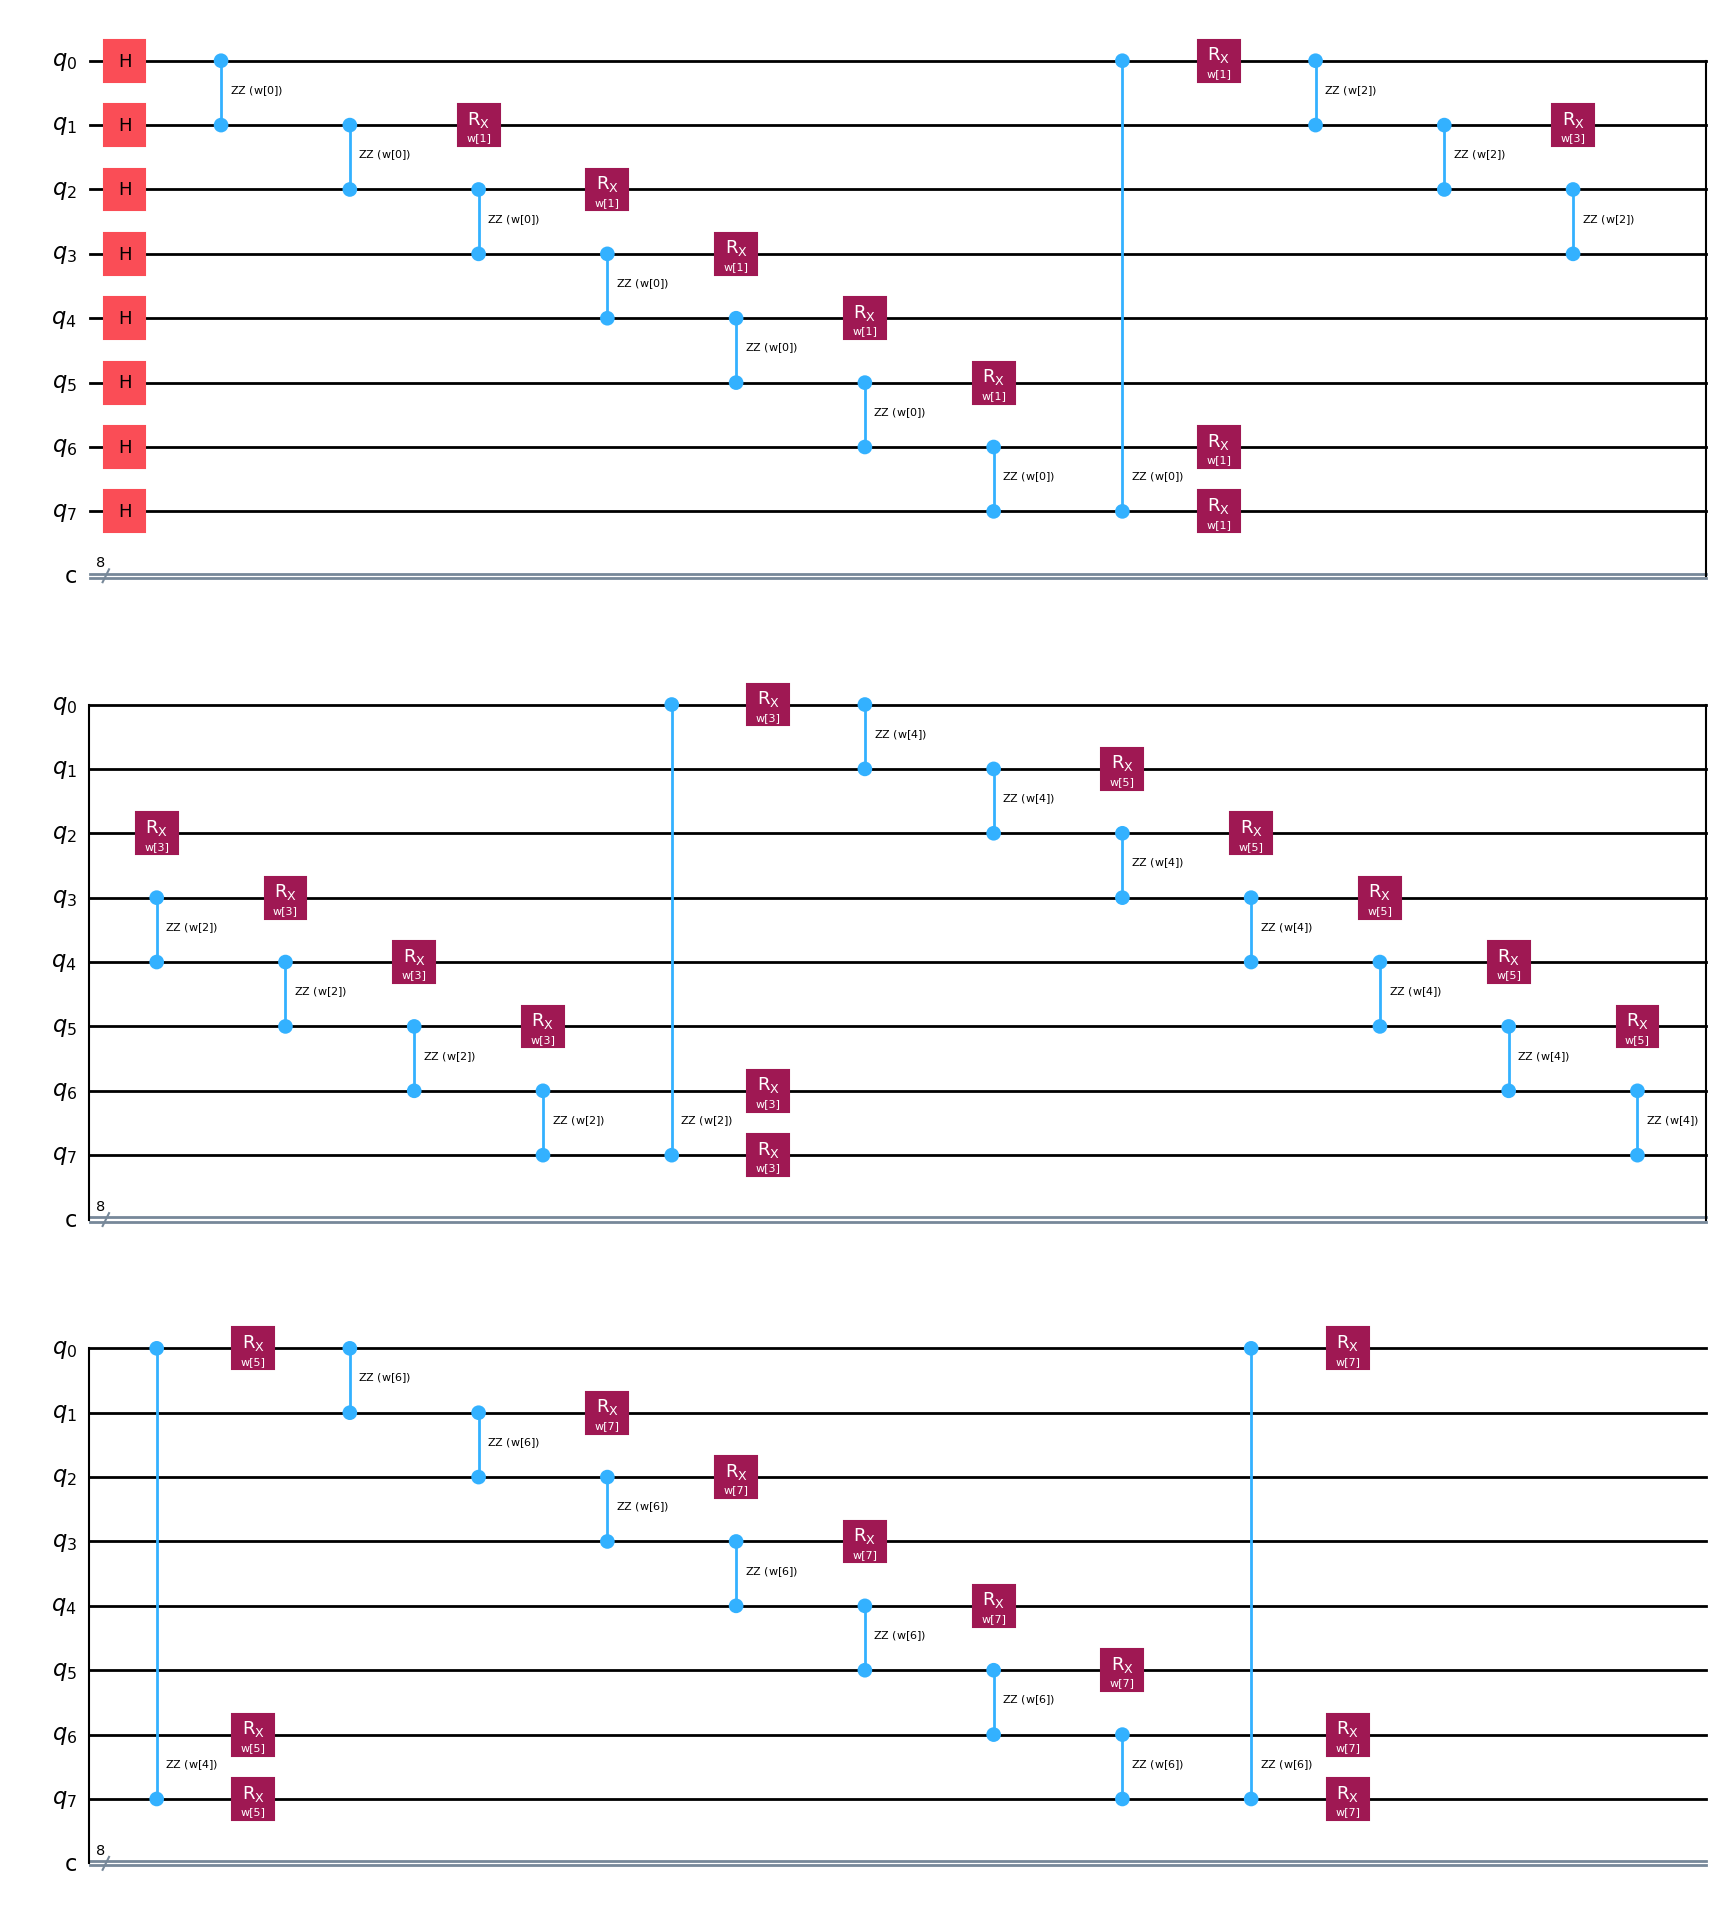

In [6]:
"""Circuit construction"""
layer = 4  # Define the number of layers in the quantum circuit

# This needs to be determined based on the circuit
num_p = layer * 2  # Calculate the number of parameters

weights = ParameterVector("w", num_p)  # Create a vector of parameters (parameters of the quantum circuit)

def circuit_HVA_TIFM(weights):
    circ = QuantumCircuit(num_q, num_q)

    for j in range(num_q):
        circ.h(j) 

    for i in range(layer):
        ## Odd layers
        for j in range(num_q):
            circ.rzz(weights[2 * i], j , (j + 1) % num_q)  ## ZZ gates in odd sum
            # weights  [0]
        for j in range(num_q):
            circ.rx(weights[2 * i + 1], j)  ## YY gates in odd sum
            # weights  [1]

    return circ 

qc = circuit_HVA_TIFM(weights)
# print(qc)
qc.draw("mpl")


In [7]:
simulator = AerSimulator()


def expectation_loss(WEIGHTS):
    qc = circuit_HVA_TIFM(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hpsi = Hmat.dot(psi)
    expectation = np.inner(np.conjugate(psi),Hpsi)
    return np.real(expectation)


In [8]:
weights_dict = {}

if num_q == 4 or num_q == 5:
    omegas = [2,4]
elif num_q == 6 or num_q == 7:
    omegas = [2, 4, 6]
elif num_q == 8 or num_q == 9:
    omegas = [2, 4, 6, 8]
elif num_q == 10 or num_q == 11:
    omegas = [2, 4, 6, 8, 10]
elif num_q == 12 or num_q ==13:
    omegas = [2, 4, 6, 8, 10, 12]

# Construct weights_dict
weights_dict = {}
for j in range(num_p): 
    weights_dict[f'weights_{j}'] = {
        'omegas': omegas,
        'scale_factor': 2.0,
        'interp_nodes': [],
        'inverse_interp_matrix': [],
    }


In [10]:
# Verify if the function can be accurately interpolated by trigonometric interpolation based on omegas

from algo.utils import check_is_trigometric  # Assuming check_is_trigometric is defined in utils module

# Define random weights
weights = np.random.normal(0, 4 * np.pi**2, num_p)

# Loop over each weight index and check trigonometric interpolation
for j in range(num_p):
    # Circuit_HEA is simple and all Hermitian generators are Y.
    omegas = weights_dict[f'weights_{j}']['omegas']  # This needs to be determined based on the circuit (i.e., parameters to test interpolation)
    
    print('\n index to check = ', j)
    print('omegas = ', omegas)
    
    opt_interp_flag = False  # Flag to indicate if optimal interpolation should be used
    
    # Call the function to check if the objective function can be interpolated using trigonometric interpolation
    check_is_trigometric(expectation_loss, j, omegas, weights, opt_interp_flag)




 index to check =  0
omegas =  [2, 4, 6, 8]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [10.12416164  7.14213598  4.97617899  1.13550409  1.4611286   0.09721188
  0.27524834 -0.01355003  0.03000756]

 index to check =  1
omegas =  [2, 4, 6, 8]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [ 2.19463505e+01  2.15391532e-01  3.70406907e-03  4.78188894e-04
  1.08521242e-03 -2.55908160e-06 -2.46930305e-06  7.37066279e-09
 -6.29879799e-09]

 index to check =  2
omegas =  [2, 4, 6, 8]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [11.80144209 -9.33165555 -4.96978723  1.5104345   2.17864202  0.17426911
  0.55289687  0.04205155  0.05111637]

 index to check =  3
omegas =  [2, 4, 6, 8]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [10.2128755   4.70978697 -3.18335211  2.28184508  0.71276821  0.17719527
  0.14767111  0.0150598   0.02161042]

 index to check =  4
omegas =  [2, 4, 6, 8]
Consistent results: 50/50
【All Passed】

In [12]:
from algo.utils import parameter_shift_for_equidistant_frequencies

# Define random weights
weights = np.random.normal(0, 4 * np.pi**2, num_p)

def central_difference(f, x, h=1e-5):
    return (f(x + h) - f(x - h)) / (2 * h)

for j in range(num_p):
    omegas = weights_dict[f'weights_{j}']['omegas']
    factor = weights_dict[f'weights_{j}']['scale_factor']
    psr_values = parameter_shift_for_equidistant_frequencies(expectation_loss, weights, j, omegas, factor)

    def fun(x):
        new_weights = weights.copy()
        new_weights[j] = x
        return expectation_loss(new_weights)

    df_values = central_difference(fun, weights[j])
    print(np.isclose(psr_values, df_values))

True
True
True
True
True
True
True
True
